In [1]:
from ultralytics import YOLO
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import os
import time
import torch
from copy import deepcopy
from model.SiameseReId import SiameseReId
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import time

/home/riccardo/anaconda3/envs/siv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = YOLO("yolov8n-seg.pt") # COCO128 classes https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml
# model = YOLO("yolov8n-seg.pt")
siamese_net = SiameseReId(os.path.join('model','weights','model_final.pt'))

In [3]:
def crop_segmentation(segment,box,image):
    img = image.copy()
    box = box.astype(int)
    w,h,c = img.shape
    mask = (cv2.resize(segment,(h,w)) > 0).astype("uint8")
    img_segm = cv2.bitwise_and(img,img,mask=mask)
    img_segm = img_segm[box[1]:box[3],box[0]:box[2]]
    return cv2.cvtColor(img_segm, cv2.COLOR_BGR2RGB)

In [198]:
file_path = 'test_aula.mp4'
cap = cv2.VideoCapture(file_path)
video_out = cv2.VideoWriter("./out.mp4", cv2.VideoWriter_fourcc(*'DIVX'), int(cap.get(cv2.CAP_PROP_FPS)), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [14]:
read = cap.read()

In [15]:
frame = read[1]
frame_copy = deepcopy(frame)

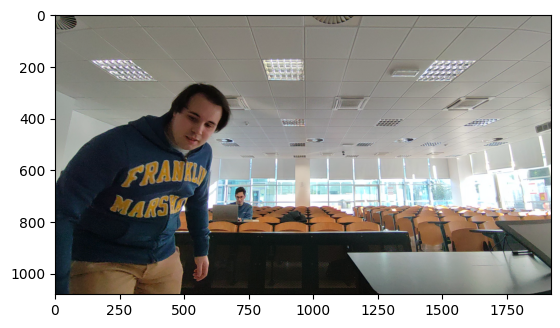

In [16]:
plt.imshow(cv2.cvtColor(frame_copy,cv2.COLOR_BGR2RGB))

In [32]:
results = model.predict(frame)[0].cpu().numpy()


0: 384x640 2 persons, 5 chairs, 11.6ms
Speed: 15.4ms pre-process, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


In [37]:
idx = np.where(results.boxes.cls == 0)
idx

(array([0, 3]),)

In [53]:
masks = results.masks.masks[idx]
boxes = results.boxes.xyxy[idx]
centers = results.boxes.xywh[idx][:,:2].astype(int)

In [54]:
centers

array([[348, 670],
       [693, 748]])

In [58]:
centers_draw = frame_copy.copy()
for center in centers:
    centers_draw = cv2.circle(centers_draw, center.tolist(), 5, (0,0,255),3)

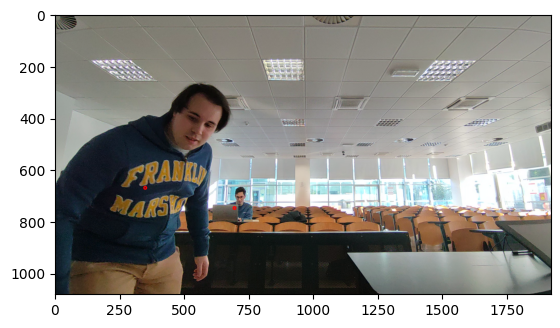

In [59]:
plt.imshow(cv2.cvtColor(centers_draw,cv2.COLOR_BGR2RGB))

In [60]:
cropped = [crop_segmentation(i[0],i[1],frame_copy) for i in zip(masks,boxes)]

In [61]:
len(cropped)

2

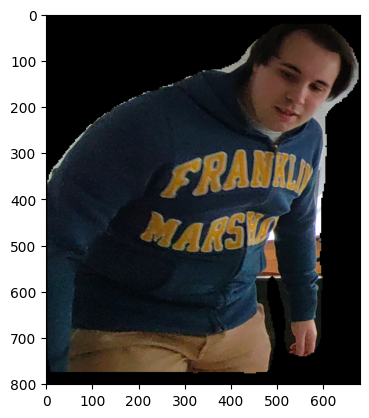

In [62]:
plt.imshow(cropped[0])

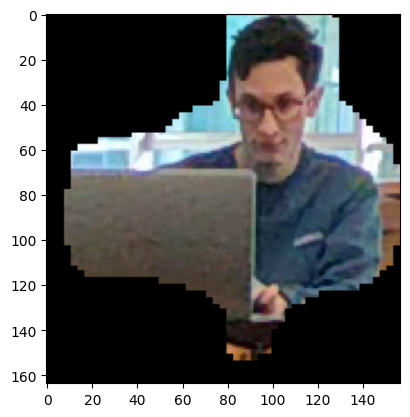

In [63]:
plt.imshow(cropped[1])

## Implementing sliding window 

In [4]:
file_path = 'test_scout.mp4'
cap = cv2.VideoCapture(file_path)
video_out = cv2.VideoWriter("./out.mp4", cv2.VideoWriter_fourcc(*'DIVX'), int(cap.get(cv2.CAP_PROP_FPS)), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [5]:
i = 0
# set initial circular buffer index to 0

In [6]:
# initialized track_id array
track_id_df = pd.DataFrame(columns=['fv'])
track_id_df

,fv


In [7]:
# get video resolution
vid_w, vid_h = int(cap.get(3)), int(cap.get(4))
vid_w, vid_h

(720, 1280)

In [8]:
# generate a circular buffer for video frame(4)
four_frames = np.zeros((4,vid_h, vid_w,3),dtype="uint8")

In [246]:
# populate circular buffer with frame
while i < 4:
    ret, frame = cap.read()
    four_frames[i] = frame.copy()
    i+=1
    if not ret:
        cap.release()
        video_out.release()
        exit() #kill the program


# four_detectiona[0] = four_detectiona[2]
# four_detectiona[1] = four_detectiona[3]
# i = 2

In [247]:
# detections array associated to frames
four_detections = [None,None,None,None]


In [248]:
# make prediction for each frame in the buffer
for frame_id in range(4):
    # deep copy of frame image (yolo draw on the predicted image)
    frame_copy = deepcopy(four_frames[frame_id])

    # get results and convert to numpy
    results = model.predict(frame_copy)[0].cpu().numpy()

    # filter prediction of class person with conf > 0.5
    idx = np.where((results.boxes.cls == 0) & (
        results.boxes.conf > 0.5))  # filter person

    # extract masks,boxes and bb centers
    masks = results.masks.masks[idx].copy()
    boxes = results.boxes.xyxy[idx].copy()
    centers = results.boxes.xywh[idx][:, :2].copy().astype(int)

    # populate detection array with associeted detections
    four_detections[frame_id] = pd.DataFrame({
                                            'box': boxes.tolist(),
                                            'mask': masks.tolist(),
                                            'center': centers.tolist(),
                                            'box_id': np.full(len(idx[0]), -1).tolist(),
                                            'trak_id': np.full(len(idx[0]), -1).tolist()
                                            })

    # delete yolo drawed frame
    del frame_copy, results



0: 640x384 2 persons, 1 bottle, 1 cup, 1 knife, 1 pizza, 1 dining table, 11.7ms
Speed: 0.4ms pre-process, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 persons, 1 bottle, 2 wine glasss, 1 cup, 1 knife, 1 pizza, 1 dining table, 11.5ms
Speed: 0.3ms pre-process, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 persons, 1 bottle, 1 wine glass, 1 cup, 1 knife, 1 pizza, 1 dining table, 9.2ms
Speed: 0.3ms pre-process, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 2 persons, 1 bottle, 1 wine glass, 1 pizza, 1 dining table, 7.6ms
Speed: 0.3ms pre-process, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


In [249]:
# count the max detections number in per frame
cluster_numbers = max([len(j) for j in four_detections])
cluster_numbers

2

In [250]:
# create a list containing all the detections per frame
centers = []

for j in four_detections:
    for val in j['center'].values:
        centers.append(val)

In [251]:
cluster_numbers

2

In [252]:
# fit kmeans cluster with n_cluster equal to max detections per frame
kmeans = KMeans(n_clusters=cluster_numbers, random_state=0, n_init="auto").fit(centers)

In [253]:
# for each detections find the box number
for det in four_detections:
    det['box_id'] = det['center'].apply(lambda x: kmeans.predict(np.array([x]).tolist())[0])

del cluster_numbers, centers, kmeans

In [254]:
# function to get tid given the detection image [return -1 if no similarity find]
def get_tid(track_id_df,det_img):
    similarity = track_id_df['fv'].apply(lambda x: siamese_net.similarity(det_img,torch.tensor(x)).detach().cpu().numpy()[0][0])
    if similarity.empty:
        return -1
    else:
        return similarity.idxmax() if similarity.loc[similarity.idxmax()] > 0.8 else -1

In [255]:
# for each detection calculate feature vector and the correspondent track_id [-1 if no similarity found]
for i,det in enumerate(four_detections):
    det['fv'] = det.apply(lambda x: siamese_net.fv_encoding(Image.fromarray(crop_segmentation(np.array(x['mask']),np.array(x['box']),four_frames[i]))).cpu().numpy(),axis=1)
    det['trak_id'] = det.apply(lambda x: get_tid(track_id_df,Image.fromarray(crop_segmentation(np.array(x['mask']),np.array(x['box']),four_frames[i]))),axis=1)

In [256]:
# for each detection id get the four tid prediction
counter = {}

for i,det in enumerate(four_detections):
    for index, row in det.iterrows():
        tmp_box_id = row['box_id']
        if str(tmp_box_id) not in counter:
             counter[str(tmp_box_id)] = [row['trak_id']]
        else:
            counter[str(tmp_box_id)].append(row['trak_id'])


In [257]:
# for each detection count the occurence of tid associeted, if < 3 return None (not valid)
for key in counter:
    # counter[key] = max(counter[key],key=counter[key].count)
    counting_inst = {str(u):counter[key].count(u) for u in np.unique(np.array(counter[key]))}
    candidate_tid = max(counting_inst,key=counting_inst.get)
    tid = candidate_tid if counting_inst[candidate_tid] >= 3 else None
    counter[key] = tid

In [258]:
counter

{'1': '0', '0': '1'}

In [259]:
# for each detection, set the processed tid
for det in four_detections:
    det['trak_id'] = det['box_id'].apply(lambda x: counter[str(x)])

In [260]:
del counter

In [261]:
added = {}
for det in four_detections:
    for index, row in det.iterrows():
        if row['trak_id'] is not None:
            if int(row['trak_id']) == -1:
                if row['box_id'] not in added:
                    # add fv to trak_id and return last index
                    track_id_df = pd.concat([track_id_df, pd.DataFrame({"fv": [row['fv']]})], ignore_index=True)
                    new_tid = track_id_df.index[-1]
                    added[row['box_id']] = new_tid
                    det._set_value(index,'trak_id',new_tid)
                    print(f"aggiunto {row['box_id']}")
                else:
                    det._set_value(index,'trak_id',added[row['box_id']])

            # track_id_df.loc[eval(row['trak_id'])]['fv'] = row['fv']

In [262]:
added

{}

In [263]:
del added

In [264]:
four_detections[0]

,box,mask,center,box_id,trak_id,fv
0,"[131.0, 247.0, 536.0, 906.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[333, 576]",1,0,"[[0.0, 0.0, 0.0, 0.0, 0.087439775, 0.0, 0.0, 0..."
1,"[507.0, 321.0, 720.0, 874.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[613, 597]",0,1,"[[0.0, 0.0, 0.0, 0.0, 0.06645149, 0.0, 0.0, 0...."


In [265]:
four_detections[1]

,box,mask,center,box_id,trak_id,fv
0,"[508.0, 322.0, 720.0, 874.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[614, 598]",0,1,"[[0.0, 0.0, 0.0, 0.0, 0.06587291, 0.0, 0.0, 0...."
1,"[131.0, 247.0, 542.0, 902.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[336, 574]",1,0,"[[0.0, 0.0, 0.0, 0.0, 0.094374314, 0.0, 0.0, 0..."


In [266]:
four_detections[2]

,box,mask,center,box_id,trak_id,fv
0,"[512.0, 322.0, 720.0, 872.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[616, 597]",0,1,"[[0.0, 0.0, 0.0, 0.0, 0.066997305, 0.0, 0.0, 0..."
1,"[131.0, 246.0, 568.0, 902.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[349, 574]",1,0,"[[0.0, 0.0, 0.0, 0.0, 0.10683888, 0.0, 0.0, 0...."


In [267]:
four_detections[3]

,box,mask,center,box_id,trak_id,fv
0,"[514.0, 322.0, 720.0, 872.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[617, 597]",0,1,"[[0.0, 0.0, 0.0, 0.0, 0.06612538, 0.0, 0.0, 0...."
1,"[131.0, 247.0, 586.0, 903.0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[358, 575]",1,0,"[[0.0, 0.0, 0.0, 0.0, 0.10694806, 0.0, 0.0, 0...."


In [268]:
track_id_df

,fv
0,"[[0.0, 0.0, 0.0, 0.0, 0.12508103, 0.0, 0.0, 0...."
1,"[[0.0, 0.0, 0.0, 0.0, 0.048906446, 0.0, 0.0, 0..."


In [269]:
for f in range(2):
    drew_frame = four_frames[f].copy()
    for indx, row in four_detections[f].iterrows():
        if row['trak_id'] is not None:
            drew_frame = cv2.rectangle(drew_frame, (int(row['box'][0]), int(row['box'][1])), (int(row['box'][2]), int(row['box'][3])), (255,0,0), 3)
            drew_frame = cv2.putText(drew_frame, str(row['trak_id']), (int(row['box'][0]),int(row['box'][1])), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 2, cv2.LINE_AA)

    cv2.imwrite(f"./prova/{time.time()}.jpg", drew_frame)
    video_out.write(drew_frame.copy())
    del drew_frame
        

In [270]:
del four_detections

four_frames[0] = four_frames[2]
four_frames[1] = four_frames[3]

i = 2